In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Loading the data:

In [2]:
def load_dat(filename):
    data_path = os.path.join("data", filename)
    return pd.read_csv(data_path, 
                       delimiter=r'\s+',
                       header=None,
                       usecols=[2,5,7],
                       names=['t_lb','V_m/V_v','MAR'])

masses = [10.0,10.5,11.0,11.5,12.0,12.5,13.5]
data = {}
for i, fname in enumerate(os.listdir('data')):
    path = os.path.join('data', fname)
    data[masses[i]] = load_dat(fname)

data[10].head()

,t_lb,V_m/V_v,MAR
0,0.0015,0.12801,0.26892
1,0.1269,0.12806,0.18649
2,0.2519,0.12809,0.19827
3,0.3763,0.12812,0.20586
4,0.5002,0.12814,0.21330


Converting the time to cosmic

In [3]:
for mass, df in data.items():
    df['t_c'] = 13.8 - df['t_lb'] 

data[10].head()

,t_lb,V_m/V_v,MAR,t_c
0,0.0015,0.12801,0.26892,13.7985
1,0.1269,0.12806,0.18649,13.6731
2,0.2519,0.12809,0.19827,13.5481
3,0.3763,0.12812,0.20586,13.4237
4,0.5002,0.12814,0.21330,13.2998


Now the interpolation plot:

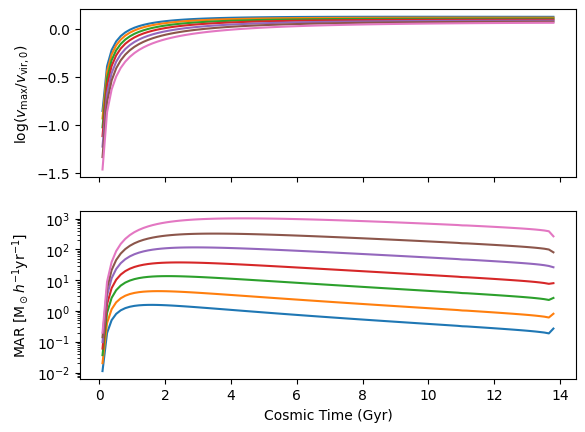

In [4]:
t_space = np.linspace(0.1,13.8,100)

fig, ax = plt.subplots(2,sharex=True)
ax[1].set_xlabel('Cosmic Time (Gyr)')
ax[0].set_ylabel(r'$\log(v_{\text{max}}/v_{\text{vir},0})$')
ax[1].set_ylabel(r'MAR $[\text{M}_\odot h^{-1} \text{yr}^{-1}]$')
for mass, df in data.items():
    y_v = np.interp(t_space,df['t_c'][::-1],df['V_m/V_v'][::-1])
    y_MAR = np.interp(t_space,df['t_c'][::-1],df['MAR'][::-1])
    ax[0].plot(t_space,y_v)
    ax[1].plot(t_space,y_MAR)

ax[1].set_yscale('log')

Now for the calculations in (iii) - (v): we will use eulers methods to solve the different time evolutions. <font color='red'> Apparently it needs to be forwards in time, but then I don't know the initial values. I emailed Ryan. </font>
We will go backwards in time. Our rough sketch:

```python
# Initialize
M_dm, M_g, M_star, SFR, dM_g = zeroes
dM_dm = interp(data) * h # ?

# Start values
X,Y,Z fractions
M_dm[0] = X * M_vir
M_g[0] = Y * M_vir
M_star[0] = Z * M_vir
SFR[0] = A * M_g
dM_g[0] = gamma(0) * f_b * dM_dm[0] - (1-R) * SFR # Assuming here that gas outflow = 0

for i,t enumerate t_space:
    M_dm[i+1] = M_dm[0] - dM_dm[0]
    M_star[i+1] = M_star[i] + (1-R) * SFR[i] * dt
    M_g[i+1] = M_g[i] - dM_gas * dt

    SFR[i+1] = A * M_g[i+1]
    dM_g[i+1] = gamma(M_dm[i+1]) * f_b * dM_dm[i+1]

```


In [20]:
dm_ratio = 0.85
star_ratio = 0.075
g_ratio = 1 - dm_ratio - star_ratio

def gamma(M_dm):
    M_crit = 6e11 # Critical Mass [Solar Masses]
    if M_dm > M_crit:
        return 0.3
    else:
        return 1

def mass_evolution(df, M_vir, fractions, n_steps=100):
    ''' Models the backwards evolution of the different masses

    INPUT
    -----
    df : (pd.DataFrame)
        dataframe with columns ['t_c','MAR']
    M_vir : (float)
        Log_10 of the virial mass of the galaxy
    fractions : (list - float)
        List with three fractions of the virial mass for (in this order):
        fraction of DM, fraction of gas, fraction of stars
    n_steps : int
        number of time steps for the evolution

    OUTPUT
    -----
    t_reverse, M_dm, M_g, M_star, SFR : np.ndarray
        the results

    '''
    
    M_vir = 10**M_vir
    R = 0.4
    h = 0.7 # dim.-less Hubble
    A = 2e-10
    f_b = fractions[1] + fractions[2] # ???

    # Initialize
    t_cosmic = np.linspace(0.1,13.8,n_steps) # cosmic time in Gyr
    t_reverse = t_cosmic[::-1]
    dt = 13.8 / n_steps * 1e9 # in yr

    dM_dm = np.interp(t_reverse,df['t_c'],df['MAR']) * h # Not sure if this h is correct ???

    M_dm, M_g, M_star, SFR, dM_g = np.zeros((5,n_steps))

    # Initial Values at t=t_0
    
    M_dm[0] = fractions[0] * M_vir
    M_g[0] = fractions[1] * M_vir
    M_star[0] = fractions[2] * M_vir
    SFR[0] = A * M_g[0]
    dM_g[0] = gamma(0) * f_b * dM_dm[0] - (1-R) * SFR[0] # Assuming here that gas outflow = 0

    for i in range(n_steps-1):

        M_dm[i+1] = M_dm[0] - dM_dm[0]
        M_star[i+1] = M_star[i] - (1-R) * SFR[i] * dt 
        M_g[i+1] = M_g[i] - dM_g[i] * dt

        SFR[i+1] = A * M_g[i+1]
        dM_g[i+1] = gamma(M_dm[i+1]) * f_b * dM_dm[i+1]
    
    return t_reverse, M_dm, M_g, M_star, SFR


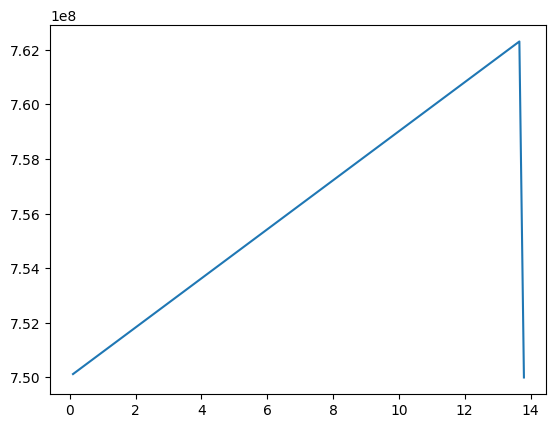

In [ ]:
dm_ratio = 0.85
star_ratio = 0.075
g_ratio = 1 - dm_ratio - star_ratio
fractions = [dm_ratio,g_ratio,star_ratio]

# A first test.
t_reverse, M_dm, M_g, M_star, SFR = mass_evolution(data[10.0],10.0,fractions)

plt.plot(t_reverse,M_g)
plt.show()
